In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [56]:
from scipy.io import arff

file_path = "heat_flux dataset"



In [57]:
# Read the first few lines of the file to inspect its structure
with open(file_path, "r", encoding="utf-8") as file:
    file_preview = [next(file) for _ in range(10)]

file_preview


['% Context\n',
 '% This dataset was prepared for the journal article entitled "On the prediction of critical heat flux using a physics-informed machine learning-aided framework" (doi: 10.1016/j.applthermaleng.2019.114540). The dataset contains processed and compiled records of experimental critical heat flux and boundary conditions used for the work presented in the article. \n',
 '% Acknowledgements\n',
 '% Zhao, Xingang (2020), Data for: On the prediction of critical heat flux using a physics-informed machine learning-aided framework, Mendeley Data, V1, doi: 10.17632/5p5h37tyv7.1\n',
 '@RELATION Predicting-Critical-Heat-Flux\n',
 '\n',
 '@ATTRIBUTE id INTEGER\n',
 '@ATTRIBUTE author STRING\n',
 '@ATTRIBUTE geometry STRING\n',
 '@ATTRIBUTE pressure_[MPa] REAL\n']

In [58]:
# Read the file and manually parse the ARFF format
with open(file_path, "r", encoding="utf-8") as file:
    lines = file.readlines()

# Extract attributes (column names) and data
attributes = []
data_section = False
data_rows = []

for line in lines:
    line = line.strip()
    
    if line.lower() == "@data":
        data_section = True
        continue

    if data_section:
        data_rows.append(line.split(","))  # Assuming data is comma-separated
    elif line.lower().startswith("@attribute"):
        attributes.append(line.split()[1])  # Extract attribute name

# Convert to Pandas DataFrame
df = pd.DataFrame(data_rows, columns=attributes)

# Display dataset info
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1865 entries, 0 to 1864
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   1865 non-null   object
 1   author               1865 non-null   object
 2   geometry             1865 non-null   object
 3   pressure_[MPa]       1865 non-null   object
 4   mass_flux_[kg/m2-s]  1865 non-null   object
 5   x_e_out_[-]          1865 non-null   object
 6   D_e_[mm]             1865 non-null   object
 7   D_h_[mm]             1865 non-null   object
 8   length_[mm]          1865 non-null   object
 9   chf_exp_[MW/m2]      1865 non-null   object
dtypes: object(10)
memory usage: 145.8+ KB


(None,
   id   author geometry pressure_[MPa] mass_flux_[kg/m2-s] x_e_out_[-]  \
 0  1  Inasaka     tube           0.39                5600     -0.1041   
 1  2  Inasaka     tube           0.31                6700     -0.0596   
 2  3  Inasaka     tube           0.33                4300     -0.0395   
 3  4  Inasaka     tube           0.62                6400      -0.146   
 4  5  Inasaka     tube           0.64                4700     -0.0849   
 
   D_e_[mm] D_h_[mm] length_[mm] chf_exp_[MW/m2]  
 0      3.0      3.0         100            11.3  
 1      3.0      3.0         100            10.6  
 2      3.0      3.0         100             7.3  
 3      3.0      3.0         100            12.8  
 4      3.0      3.0         100            11.0  )

In [59]:
df.isnull().sum()

id                     0
author                 0
geometry               0
pressure_[MPa]         0
mass_flux_[kg/m2-s]    0
x_e_out_[-]            0
D_e_[mm]               0
D_h_[mm]               0
length_[mm]            0
chf_exp_[MW/m2]        0
dtype: int64

In [60]:
df.columns

Index(['id', 'author', 'geometry', 'pressure_[MPa]', 'mass_flux_[kg/m2-s]',
       'x_e_out_[-]', 'D_e_[mm]', 'D_h_[mm]', 'length_[mm]',
       'chf_exp_[MW/m2]'],
      dtype='object')

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


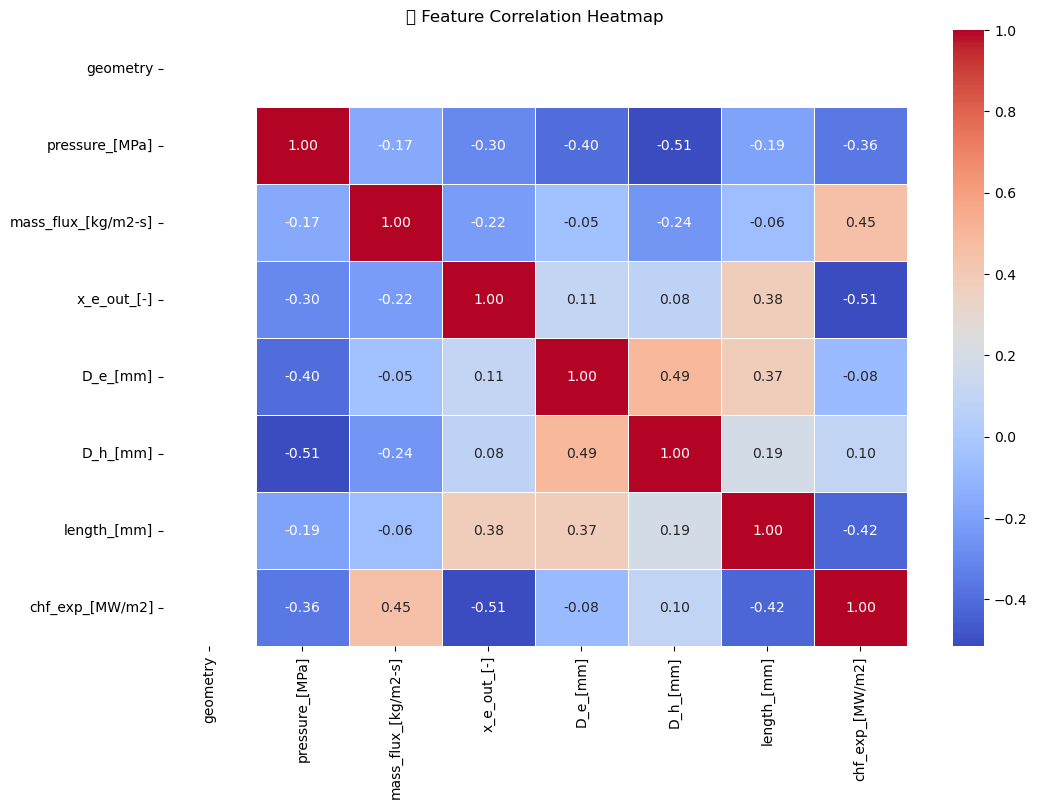

In [61]:
from sklearn.preprocessing import LabelEncoder
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Encode categorical column (if exists)
if "geometry" in df.columns:
    df["geometry"] = LabelEncoder().fit_transform(df["geometry"])

# Drop unnecessary columns
df = df.drop(columns=["id", "author"], errors="ignore")

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("🔹 Feature Correlation Heatmap")
plt.show()

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [63]:
# Split dataset
X = df.drop(columns=["chf_exp_[MW/m2]"])
y = df["chf_exp_[MW/m2]"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features for models that require it (Logistic Regression & KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [64]:
results = {}

In [65]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

results["Linear Regression"] = {
    "RMSE": mean_squared_error(y_test, y_pred_lr),
    "MAE": mean_absolute_error(y_test, y_pred_lr),
    "R² Score": r2_score(y_test, y_pred_lr)
}

results 

{'Linear Regression': {'RMSE': 1.3385538398175083,
  'MAE': 0.7778018475038881,
  'R² Score': 0.6417845200817583}}

In [66]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

results["Random Forest"] = {
    "RMSE": mean_squared_error(y_test, y_pred_rf),
    "MAE": mean_absolute_error(y_test, y_pred_rf),
    "R² Score": r2_score(y_test, y_pred_rf)
}

results


{'Linear Regression': {'RMSE': 1.3385538398175083,
  'MAE': 0.7778018475038881,
  'R² Score': 0.6417845200817583},
 'Random Forest': {'RMSE': 0.4836668686327073,
  'MAE': 0.3139356568364609,
  'R² Score': 0.870564071228215}}

In [67]:
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

results["Gradient Boosting"] = {
    "RMSE": mean_squared_error(y_test, y_pred_gb),
    "MAE": mean_absolute_error(y_test, y_pred_gb),
    "R² Score": r2_score(y_test, y_pred_gb)
}

results

{'Linear Regression': {'RMSE': 1.3385538398175083,
  'MAE': 0.7778018475038881,
  'R² Score': 0.6417845200817583},
 'Random Forest': {'RMSE': 0.4836668686327073,
  'MAE': 0.3139356568364609,
  'R² Score': 0.870564071228215},
 'Gradient Boosting': {'RMSE': 0.4611091011709998,
  'MAE': 0.4094365898403183,
  'R² Score': 0.8766008411038901}}

In [68]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)

results["KNN"] = {
    "RMSE": mean_squared_error(y_test, y_pred_knn),
    "MAE": mean_absolute_error(y_test, y_pred_knn),
    "R² Score": r2_score(y_test, y_pred_knn)
}

results


{'Linear Regression': {'RMSE': 1.3385538398175083,
  'MAE': 0.7778018475038881,
  'R² Score': 0.6417845200817583},
 'Random Forest': {'RMSE': 0.4836668686327073,
  'MAE': 0.3139356568364609,
  'R² Score': 0.870564071228215},
 'Gradient Boosting': {'RMSE': 0.4611091011709998,
  'MAE': 0.4094365898403183,
  'R² Score': 0.8766008411038901},
 'KNN': {'RMSE': 0.6843978552278821,
  'MAE': 0.4358713136729222,
  'R² Score': 0.8168456890767314}}

In [69]:
# Converting results to DataFrame
results_df = pd.DataFrame(results).T
print(" Model Performance Comparison:\n", results_df)

 Model Performance Comparison:
                        RMSE       MAE  R² Score
Linear Regression  1.338554  0.777802  0.641785
Random Forest      0.483667  0.313936  0.870564
Gradient Boosting  0.461109  0.409437  0.876601
KNN                0.684398  0.435871  0.816846


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


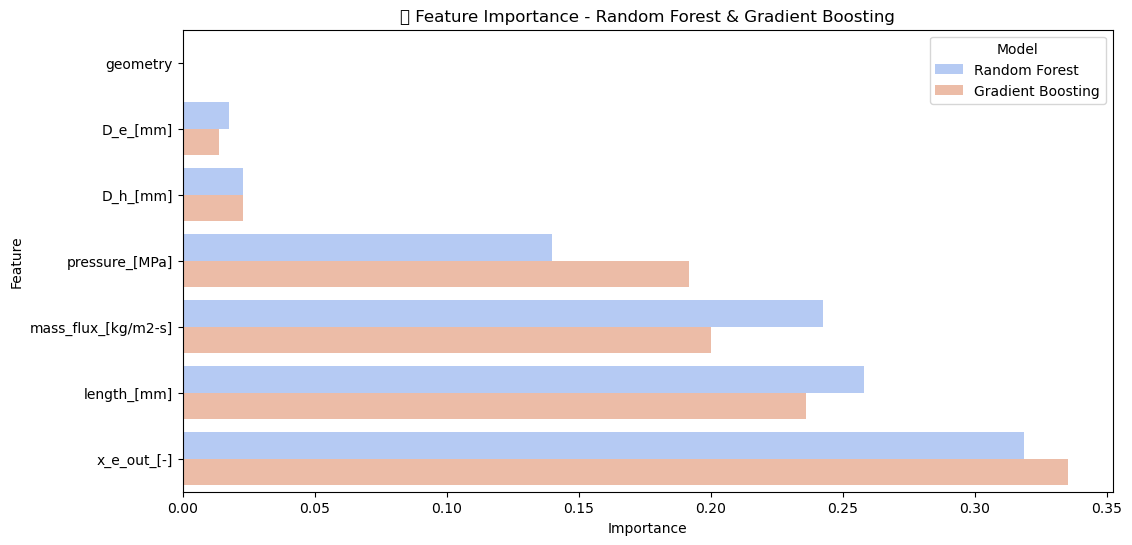

In [70]:
# Feature Importance Analysis
rf_importance = rf_model.feature_importances_
gb_importance = gb_model.feature_importances_


feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Random Forest": rf_importance,
    "Gradient Boosting": gb_importance
}).sort_values(by="Random Forest")

# Plot Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance_df.melt(id_vars="Feature", var_name="Model", value_name="Importance"),
            x="Importance", y="Feature", hue="Model", palette="coolwarm")
plt.title("🔹 Feature Importance - Random Forest & Gradient Boosting")
plt.show()